# Проанализировать итоги А/В теста. Сделать выводы для менеджеров.

Во время тестирования одной гипотезы целевой группе был предложен новый формат оплаты услуг на сайте, у контрольной группы оставался базовый способ. 

-- Проанализировать итоги А/В теста.

-- Сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

# Этап 1. Проверка данных. Подготовка для выполнения поставленной задачи.

Описание входных данных:

groups.csv - принадлежность пользователя к контрольной или экспериментальной группе 

groups_add.csv - дополнительный файл с пользователями, который прислали спустя несколько дней

active_studs.csv - пользователи, которые зашли на платформу в дни проведения эксперимента

checks.csv - информация об оплатах пользователей в дни проведения эксперимента

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2
from scipy.stats import chi2_contingency
from scipy.stats import norm
from tqdm.auto import tqdm

In [2]:
# Информация о принадлежности пользователя к контрольной или экспериментальной группе
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Y2Uxx7pkplu7WQ', sep=';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.shape

# Количество строк - 74484, столбцов - 2

(74484, 2)

In [5]:
# Количество уникальных значений
groups.nunique()

# Соответствует количеству строк => Все id уникальные

id     74484
grp        2
dtype: int64

In [6]:
# Проверка на пустые значения
groups.isna().sum()

# Пустые значения отсутствуют

id     0
grp    0
dtype: int64

In [7]:
# Типы данных
groups.dtypes

# Корректные

id      int64
grp    object
dtype: object

In [8]:
# Количество пользователей в группах А и В
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

In [9]:
# Дополнительный файл с пользователями, который прислали спустя несколько дней после передачи данных
groups_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/PM8gm7EU7FVWPg', sep=',')

In [10]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
groups_add.shape

# Количество строк - 92, столбцов - 2

(92, 2)

In [12]:
# Количество уникальных значений
groups_add.nunique()

# Соответствует количеству строк => Все id уникальные

id     92
grp     2
dtype: int64

In [13]:
# Проверка на пустые значения
groups_add.isna().sum()

# Пустые значения отсутствуют

id     0
grp    0
dtype: int64

In [14]:
# Типы данных
groups_add.dtypes

# Корректные

id      int64
grp    object
dtype: object

In [15]:
# Количество пользователей в группах А и В
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [16]:
# Добавление второй таблицы к первой, как продолжение
groups_users = groups.append(groups_add)

In [17]:
# Все пользователи и их принадлежность к группе
groups_users.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [18]:
groups_users.shape[0]

74576

In [19]:
# Количество всех пользователей в группах А и В
groups_users.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

In [20]:
# Информация о пользователях, которые зашли на платформу в дни проведения эксперимента
active_users = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/b1UCahpVw1T_1g')

In [21]:
active_users.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [22]:
# Количество строк
active_users.shape[0]

8341

In [23]:
active_users.nunique()

# Все значения уникальные

student_id    8341
dtype: int64

In [24]:
# Переименование столбца для мерджа
active_users = active_users.rename(columns={'student_id': 'id'})

In [25]:
# Добавление группы пользователям, которые зашли на платформу в дни проведения эксперимента
active_users = active_users.merge(groups_users, how='left', on='id')

In [26]:
active_users

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [27]:
# Количество активных пользователей в группах А и В
active_users.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [28]:
# Информация об оплатах пользователей в дни проведения эксперимента
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/QGMD0lDBr70lsA', sep=';')

In [29]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [30]:
# Информация о данных
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [31]:
# Количество уникальных значений
checks.nunique()

# Количество student_id совпадает с количеством строк в ДФ => Все значения уникальные, пропусков нет

student_id    541
rev            39
dtype: int64

In [32]:
# Описательная статистика оплат
checks.rev.describe().round(2)

count     541.00
mean     1059.75
std       762.71
min       199.00
25%       290.00
50%       840.00
75%      1900.00
max      4650.00
Name: rev, dtype: float64

Средний чек - 1059.75

Минимальный чек - 199

Максимальный чек - 4650

In [33]:
# Переименование столбца для мерджа
checks = checks.rename(columns={'student_id': 'id'})

In [34]:
# Мердж всех пользователей и групп с оплатами, удаление строк без оплат
groups_users_checks = groups_users.merge(checks, how='left', on='id').dropna()

In [35]:
# Все платежи пользователей с привязкой к группам
groups_users_checks

,id,grp,rev
1,1627,A,990.0
39,3185,B,690.0
121,25973,B,690.0
125,26280,B,690.0
220,100300,B,990.0
...,...,...,...
74365,5645737,B,1900.0
74381,5651566,B,1900.0
74402,5662322,B,1900.0
74452,5681918,B,1900.0


In [36]:
groups_users_checks.grp.value_counts()

B    434
A    107
Name: grp, dtype: int64

# Итоги 1 этапа по проверке данных.
Имееются id пользователей, все они уникальные, всем присвоена группа А (контрольная) или В (целевая).

Также пользователи делятся на группы активности: часть из них заходили на платформу (активные), часть не заходили (не активные).

In [37]:
# Мердж активных пользователей и оплат *в дни проведения эксперимента*, удаление строк без оплат
active_users_checks = active_users.merge(checks, how='left', on='id').dropna()
active_users_checks.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

# Итоги 1 этапа по проверке данных оплат.
В дни проведения эксперимента всего прошло оплат 541.
Из них 392 оплаты произвели пользователи, которые зашли на платформу в дни проведения эксперимента.
Значит остальные 149 оплат произвели пользователи, которые НЕ заходили на платформу в дни проведения эксперимента.

Есть ли пользователи в целевой группе среди 149 оплат неактивных пользователей, которым была предложена новая механика оплаты услуг на сайте?

In [38]:
# Добавление оплат активных пользователей ко всем имеющимся оплатам, удаление всех дубликатов
not_active_users_checks = groups_users_checks.append(active_users_checks).drop_duplicates(keep=False)

In [39]:
# Платежи пользователей, которые НЕ заходили на платформу в дни проведения эксперимента
not_active_users_checks.grp.value_counts()

B    120
A     29
Name: grp, dtype: int64

Да, среди пользователей, которые НЕ заходили на платформу в дни проведения эксперимента есть оплаты, эти пользователи так же попали в сплитовку. Плюс большинство в целевой группе! Как они смогли оплатить услугу, если не заходили на платформу? Если суммы примерно похожи между собой, возможно это автоплатеж за подписку?

In [40]:
not_active_users_checks.rev.unique()

array([ 690.    ,  630.    ,  580.    ,  290.    , 1140.    ,  990.    ,
        199.    , 1900.    , 1980.    , 1180.    ,  840.    , 1900.0001,
        398.    ])

Нет, суммы слишком отличаются между собой, я ожидала увидеть автоплатежи, примерно как 199, 299, 399... или другие похожие числа.
Тогда остается вариант, что эти пользователи ошибочно не попали в активных, возможно баг при выгрузке данных. В таком случае активными считаются все пользователи, имеющие оплаты.

# Что делаю дальше:

Отличаются ли группы между собой по наличию оплаты?
Отличаются ли конверсии в покупку групп между собой? 

Применю критерий хи-квадрат, для этого потребуются категориальный переменные: одна категория уже есть - группа, вторая категория будет - оплатил/не оплатил.

# Сформулирую гипотезы к проекту:

Н0 - отличий между группами нет

Н1 - есть статистически значимые отличия между группами

In [41]:
# Формирую метку о наличии оплаты
groups_users_checks['payment'] = 'paid'

In [42]:
# Соединяю всех активных со всеми оплатами
df = active_users.merge(groups_users_checks, how='outer')

In [43]:
# Заменяю NaN в оплатах на нули
df.rev = df.rev.fillna(0)

In [44]:
df

,id,grp,rev,payment
0,581585,A,0.0,NaN
1,5723133,A,0.0,NaN
2,3276743,B,0.0,NaN
3,4238589,A,0.0,NaN
4,4475369,B,0.0,NaN
...,...,...,...,...
8485,5291900,B,199.0,paid
8486,5331842,B,290.0,paid
8487,5486319,B,199.0,paid
8488,5562806,B,398.0,paid


In [45]:
# Заменяю NaN на метку "не оплатил"
df.payment = df.payment.fillna(value='not_paid')

In [46]:
df

,id,grp,rev,payment
0,581585,A,0.0,not_paid
1,5723133,A,0.0,not_paid
2,3276743,B,0.0,not_paid
3,4238589,A,0.0,not_paid
4,4475369,B,0.0,not_paid
...,...,...,...,...
8485,5291900,B,199.0,paid
8486,5331842,B,290.0,paid
8487,5486319,B,199.0,paid
8488,5562806,B,398.0,paid


In [47]:
# Таблица сопряженности и сразу разверну
hi = df.groupby(['grp', 'payment'], as_index=False) \
    .agg({'rev': 'count'}) \
    .rename(columns={'rev': 'quantity'}).reset_index() \
    .pivot(index='grp', columns='payment', values='quantity')
hi

payment,not_paid,paid
grp,,
A,1460,107
B,6489,434


In [48]:
# Вычисляю конверсию в покупку активных пользователей
conversion = hi.paid / (hi.not_paid + hi.paid)
conversion

grp
A    0.068283
B    0.062690
dtype: float64

Коеффициенты конверсии почти не отличаются между группами. Чтобы получить статистическое подтверждение такому выводу, использую критерий хи-квадрат.

In [49]:
statistic, pvalue, dof, expected_freq = chi2_contingency(hi)
statistic, pvalue, dof, expected_freq

(0.579666003588264,
 0.4464432666411111,
 1,
 array([[1467.14758539,   99.85241461],
        [6481.85241461,  441.14758539]]))

In [50]:
# Значение pvalue
pvalue

0.4464432666411111

pvalue > 0.05 - нет оснований отклонить нулевую гипотезу.

Подтвердил гипотезу об отсутствии статистически значимых различий между группами

In [51]:
# Статистика теста
statistic

0.579666003588264

Статистическую значимость теста сравниваю с критическим значением хи-квадрат.

Тест статистически значим, если критическое значение меньше статистики теста.

In [52]:
critical_value = chi2.ppf(1 - 0.05, dof)

In [53]:
critical_value <= statistic

False

Получаем подтверждение отстутствия статистической значимости между группами по критерию хи-квадрат, так же как и по значению pvalue и коэффициентам конверсии.

# Также посмотрю на различия между группами пользователей, которые совершили оплату.

In [54]:
payment = groups_users_checks[['id', 'grp', 'rev']]

In [55]:
# Рассчитаю количество оплат и их сумму
df = payment.groupby('grp', as_index=False).agg({'rev': ('count', 'sum')}).round(2)

# Выравниваю столбцы
df.columns = [' '.join(col).strip() for col in df.columns.values]

# Переименовываю поля
df = df.rename(columns={'rev count': 'quantity', 'rev sum': 'amount'})

# Средний чек (ARPPU)
df['ARPPU'] = round((df.amount / df.quantity), 2)

# Медианное значение
med = payment.groupby('grp', as_index=False).agg({'rev': 'median'}).rename(columns={'rev': 'median_rev'})
df = df.merge(med, on='grp')

df

,grp,quantity,amount,ARPPU,median_rev
0,A,107,92096.0,860.71,690.0
1,B,434,481230.0,1108.82,935.0


# И медианное, и среднее значения больше в целевой группе В. Но гипотезу нужно проверить на статзначимость.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


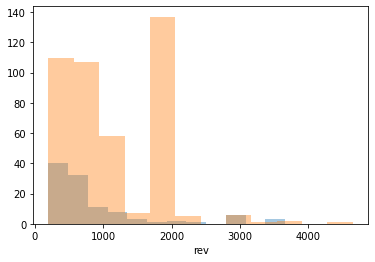

In [56]:
# Посмотрю распределение оплат
sns.distplot(payment.query('grp == "A"').rev, kde=False)
sns.distplot(payment.query('grp == "B"').rev, kde=False)

Учитывая, что распределение ненормальное, тест Стьюдента проводить нежелательно и выводы делать опасно из-за высокого риска допустить ошибку I рода.  

Попробую логарифмировать данные, возможно, распределение станет нормальным?

In [57]:
payment_log = payment.copy()

In [58]:
# Добавляю колонку с логарифмом
payment_log['rev_log'] = np.log(payment_log.rev)

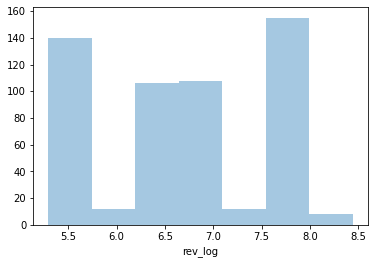

In [59]:
# Распределение на нормальность с логарифмированными значениями
sns.distplot(payment_log.rev_log, kde=False)

Распределение стало немного ровнее и по-своему симметричнее. Но нормальности не появилось. Логарифмирование данных не помогло, в таком случае провожу Bootstrap.

In [60]:
def get_bootstrap(
    # Оплаты группы A
    data_A,
    # Оплаты группы B
    data_B,
    # Количество выборок
    n_resamples=1000,
    # Статистическая мера (среднее)
    statistic=np.mean,
    # Уровень значимости
    confidence_level=0.95
):
    boot_data = []
    for i in tqdm(range(n_resamples)):    # извлечение подвыборок
        # Выборка группы A
        samples_A = data_A.sample(len(data_A), replace=True).values
        # Выборка группы B
        samples_B = data_B.sample(len(data_A), replace=True).values
        # Добавление в список
        boot_data.append(statistic(samples_A) - statistic(samples_B))
    
    # Запись в датафрейм    
    bootstrap_data = pd.DataFrame(boot_data)
    
    # Левый квантиль
    left_q = (1 - confidence_level) / 2
    # Правый квантиль
    right_q = 1 - (1 - confidence_level) / 2
    quantiles = bootstrap_data.quantile([left_q, right_q])

    pvalue_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    pvalue_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    pvalue = min(pvalue_1, pvalue_2) * 2

    # Гистограмма
    plt.hist(bootstrap_data[0], bins=30, histtype='barstacked', color='orange')
                
    plt.style.use('ggplot')
    plt.vlines(quantiles, ymin=0, ymax=100)
    plt.xlabel('bootstrap_data')
    plt.ylabel('frequency range')
    plt.title('Histogram of bootstrap_data')
    plt.show()

    return {'boot_data': boot_data,
            'quantiles': quantiles,
            'pvalue': pvalue}

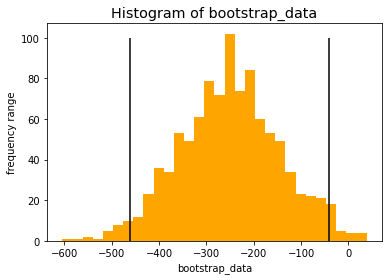

In [61]:
# Смотрю результат функции на графике
booted_data = get_bootstrap(payment.query('grp == "A"').rev,
                            payment.query('grp == "B"').rev)

In [62]:
# Значение pvalue
booted_data['pvalue']

0.01761659519776164

In [63]:
# Значения квантидей
booted_data['quantiles']

,0
0.025,-462.009594
0.975,-40.575007


# pvalue < 0.05, есть основания отклонить нулевую гипотезу о равенстве групп, т.о. бутстрап подтвердил, что статистически значимые различия в группах присутствуют. 

Учитывая наличие статистически значимых различий в группах, бОльшие значения чеков по медиане и среднемму в целевой группе, росту трат пользователей, результат тестирования говорит о большей прибыли с новым способом оплаты, чем с базовым. Раскатываем новый способ на всех пользователей сайта.